In [126]:
import os
import cv2
import math
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

from IPython.display import display

In [127]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y

def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


In [128]:
crop_size = 300
batch_size = 10
upscale_factor = 3
input_size = crop_size // upscale_factor

train_ds = image_dataset_from_directory(train_dir,
                                        batch_size=batch_size,
                                        image_size=(crop_size, crop_size),
                                        validation_split=0.2,
                                        subset="training",
                                        seed=1337,
                                        label_mode=None)

valid_ds = image_dataset_from_directory(valid_dir,
                                        batch_size=batch_size,
                                        image_size=(crop_size, crop_size),
                                        validation_split=0.2,
                                        subset="validation",
                                        seed=1337,
                                        label_mode=None)

# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

train_ds = train_ds.map(lambda x: (process_input(x, input_size, upscale_factor), process_target(x)))
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(lambda x: (process_input(x, input_size, upscale_factor), process_target(x)))
valid_ds = valid_ds.prefetch(buffer_size=32)

Found 100 files belonging to 1 classes.
Using 80 files for training.
Found 100 files belonging to 1 classes.
Using 20 files for validation.


In [129]:
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, "data")
train_dir = os.path.join(data_dir, "HR")
valid_dir = os.path.join(data_dir, "LR")
test_dir = os.path.join(data_dir, "test")

In [130]:
test_img_paths = sorted(
    [
        os.path.join(test_dir, fname)
        for fname in os.listdir(test_dir)
        if fname.endswith(".png")
    ]
)

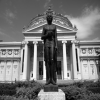

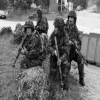

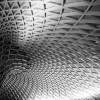

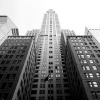

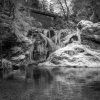

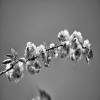

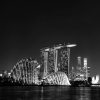

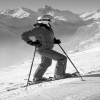

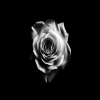

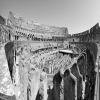

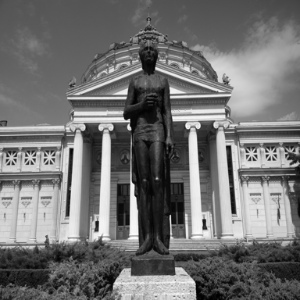

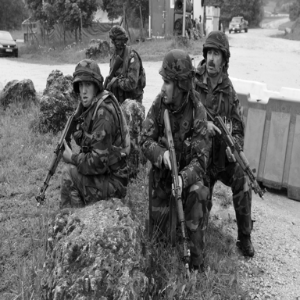

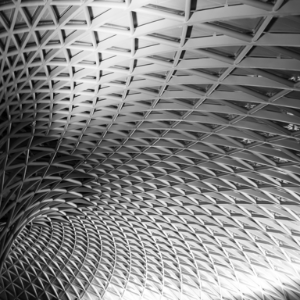

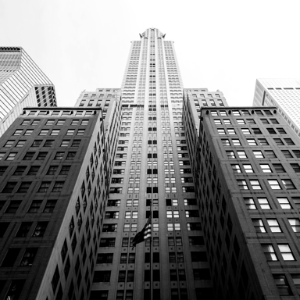

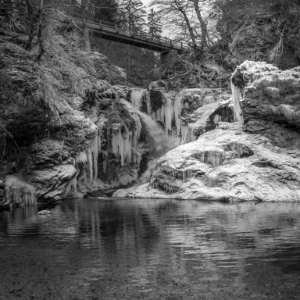

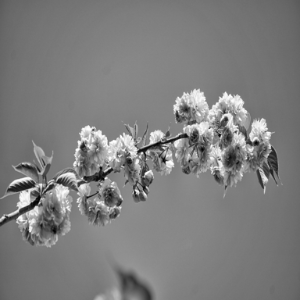

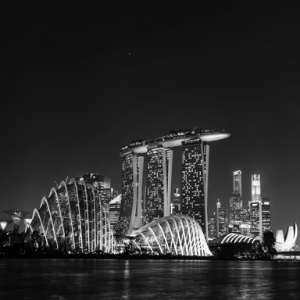

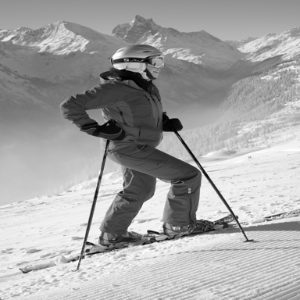

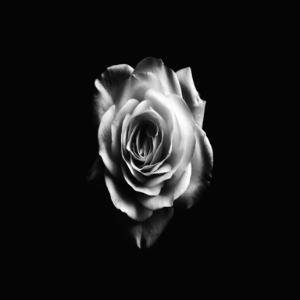

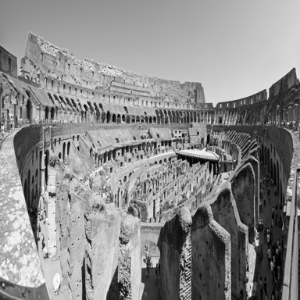

In [131]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [132]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [133]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    
    
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(256, 5, **conv_args)(inputs)
    x = layers.Conv2D(128, 3, **conv_args)(x)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


In [134]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_174 (Conv2D)         (None, None, None, 256)   6656      
                                                                 
 conv2d_175 (Conv2D)         (None, None, None, 128)   295040    
                                                                 
 conv2d_176 (Conv2D)         (None, None, None, 64)    73792     
                                                                 
 conv2d_177 (Conv2D)         (None, None, None, 32)    18464     
                                                                 
 conv2d_178 (Conv2D)         (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space_17 (TF  (None, None, None, 1)    0  

Epoch 1/20
Mean PSNR for epoch: 10.49
1/1 [==============================] - 0s 100ms/step


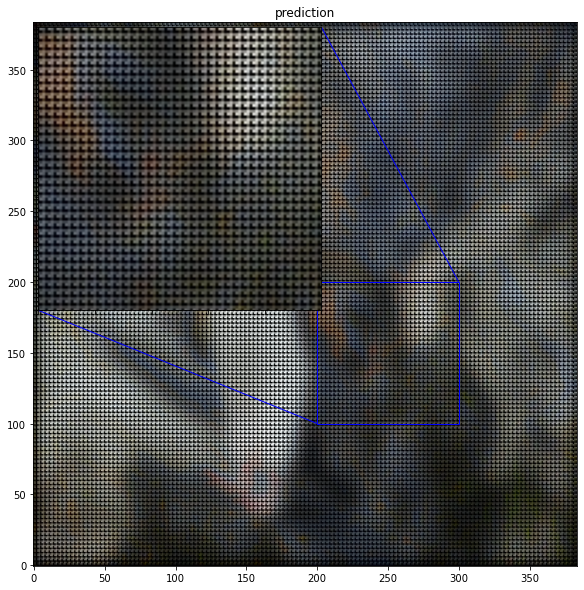

8/8 - 10s - loss: 0.1559 - val_loss: 0.0914 - 10s/epoch - 1s/step
Epoch 2/20
Mean PSNR for epoch: 16.11
8/8 - 11s - loss: 0.0687 - val_loss: 0.0241 - 11s/epoch - 1s/step
Epoch 3/20
Mean PSNR for epoch: 19.02
8/8 - 11s - loss: 0.0250 - val_loss: 0.0125 - 11s/epoch - 1s/step
Epoch 4/20
Mean PSNR for epoch: 21.21
8/8 - 11s - loss: 0.0158 - val_loss: 0.0076 - 11s/epoch - 1s/step
Epoch 5/20
Mean PSNR for epoch: 22.56
8/8 - 11s - loss: 0.0120 - val_loss: 0.0056 - 11s/epoch - 1s/step
Epoch 6/20
Mean PSNR for epoch: 24.37
8/8 - 12s - loss: 0.0101 - val_loss: 0.0039 - 12s/epoch - 1s/step
Epoch 7/20
Mean PSNR for epoch: 25.26
8/8 - 12s - loss: 0.0087 - val_loss: 0.0031 - 12s/epoch - 1s/step
Epoch 8/20
Mean PSNR for epoch: 26.71
8/8 - 11s - loss: 0.0076 - val_loss: 0.0022 - 11s/epoch - 1s/step
Epoch 9/20
Mean PSNR for epoch: 28.30
8/8 - 14s - loss: 0.0068 - val_loss: 0.0015 - 14s/epoch - 2s/step
Epoch 10/20
Mean PSNR for epoch: 29.33
8/8 - 14s - loss: 0.0060 - val_loss: 0.0012 - 14s/epoch - 2s/st

In [135]:
epochs = 20

model.compile(optimizer=optimizer, loss=loss_fn)

model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

Train Acc      0.012316640466451645
Validation Acc 0.0015672472072765231


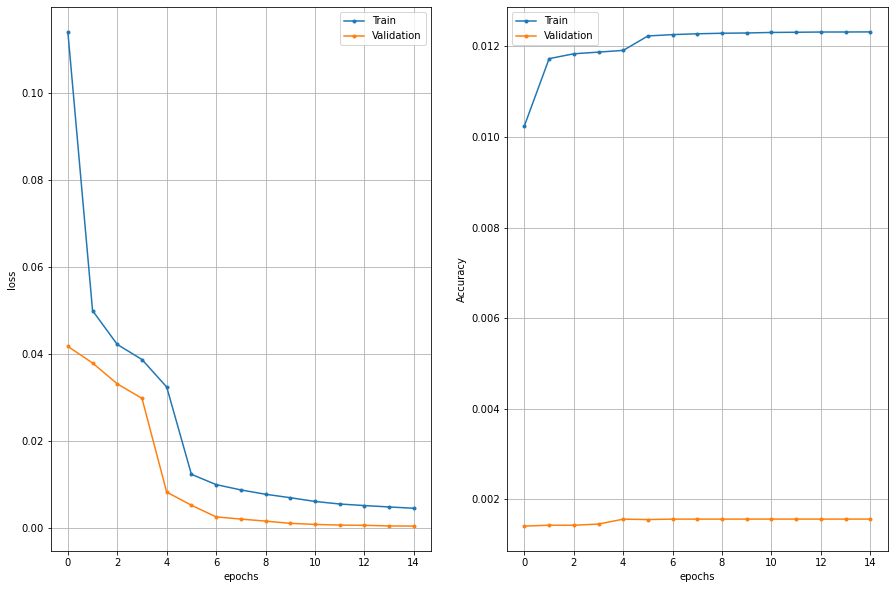

In [124]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])
    
plot_history(history)

In [125]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

Avg. PSNR of lowres images is 0.0000
Avg. PSNR of reconstructions is 0.0000
